# Running VLM analysis in CADDEE

In this example we show the steps required to use the vortex lattice method on the C172 geometry from the previous tutorials. We perform a grid convergence study of the number of chord-wise VLM panels (for the wing) and generate lift and (induced) drag polars.

```{note}
We can generate two different kinds of discretizations for VLM analysis
1. A flat lattice/chord surface
2. A camber surface 

Flat chord surfaces are easier and cheaper to project onto the central geometry. However, for cambered airfoils, the VLM analysis needs to be augmented with an airfoil model that is embedded span-wise to account for lift at zero angle of attack. This effectively shifts the lift curve slope of the flat chord surface. One advantage of this approach is that for simple geometries, no more than chord-wise panel is needed, which can save memory. 

Camber surfaces are more difficult to project. They are generated by projecting the flat chord surface onto the upper and lower wing surface and taking the average. One advantage of the camber surface is that for sufficiently refined meshes (chord-wise), the lift at zero angle of attack can be computed with reasonable accuracy for thin airfoils. To capture the curvature at the leading edge, the mesh nodal coordinates can be skewed toward the leading edge with cosine spacing. Downsides to using camber surfaces is difficulty with projection quality and projection time and increased memory costs as a higher number of chordwise panels is required to track the camber line.

In this tutorial we use both approaches.
```

We introduce a new code struture that we suggest as a template for longer run scripts. For this tutorial, this means writing three functions:

1. `define_base_config`
2. `define_conditions`
3. `define_analysis`

In addition to importing `CADDEE_alpha` and `CSDL_alpha` as in the previous examples, we also import the aerodynamic solver module `VortexAD`, which provides the VLM implementation in CSDL as well as `lsdo_airofil`, a module for subsonic, machine learning based airfoil analysis.

In [1]:
import CADDEE_alpha as cd
import csdl_alpha as csdl
import numpy as np
import matplotlib.pyplot as plt
from lsdo_airfoil.core.three_d_airfoil_aero_model import ThreeDAirfoilMLModelMaker
from VortexAD.core.vlm.vlm_solver import vlm_solver
from vedo import settings

# ensuring the vedo plots appear for jupyter notebook (not needed for regular .py file)
settings.default_backend = "vtk"

# Start the CSDL recorder
recorder = csdl.Recorder(inline=True, expand_ops=True)
recorder.start()

# import C172 geometry
c172_geom = cd.import_geometry("c172.stp")
# c172_geom.plot()

# make instance of CADDEE class
caddee = cd.CADDEE()

Importing OpenVSP file: /home/marius/Desktop/packages/lsdo_lab/CADDEE_alpha/CADDEE_alpha/utils/../../examples/test_geometries/c172.stp


## Defining the base configuration

The `define_base_config` function builds the component hierarchy and defines the meshes for the analysis. We make several VLM meshes with different chord-wise discretizations of the wing, starting with one chord-wise panel, which reduces the analysis to lifting-line theory, and increase the number of chord-wise panels in increments of four up to 20. We keep the number of spanwise panels fixed at 30

In [2]:
def define_base_config(caddee : cd.CADDEE):
    """Build the system configuration and define meshes."""

    # Make aircraft component and pass in the geometry
    aircraft = cd.aircraft.components.Aircraft(geometry=c172_geom, compute_surface_area=False)

    # instantiation configuration object and pass in system component (aircraft)
    base_config = cd.Configuration(system=aircraft)

    # Make wing geometry from aircraft component and instantiate wing component
    wing_geometry = aircraft.create_subgeometry(search_names=["MainWing"])
    wing = cd.aircraft.components.Wing(AR=7.72, S_ref=16.23, taper_ratio=0.73, geometry=wing_geometry)

    # Assign wing component to aircraft
    aircraft.comps["wing"] = wing

    # Make horizontal tail geometry component
    h_tail_geometry = aircraft.create_subgeometry(search_names=["HTail"])
    h_tail = cd.aircraft.components.Wing(AR=3.83, S_ref=4.04, taper_ratio=0.60, geometry=h_tail_geometry)

    # Assign tail component to aircraft
    aircraft.comps["h_tail"] = h_tail

    mesh_container = base_config.mesh_container

    # Tail 
    tail_chord_surface = cd.mesh.make_vlm_surface(
        wing_comp=h_tail,
        num_chordwise=1, 
        num_spanwise=10,
    )

    # Wing chord surface (lifting line)
    wing_chord_surface = cd.mesh.make_vlm_surface(
        wing_comp=wing,
        num_chordwise=1,
        num_spanwise=30,
    )
    vlm_mesh_0 = cd.mesh.VLMMesh()
    vlm_mesh_0.discretizations["wing_chord_surface"] = wing_chord_surface
    vlm_mesh_0.discretizations["h_tail_chord_surface"] = tail_chord_surface
    
    # plot meshes
    # c172_geom.plot_meshes(meshes=[wing_chord_surface.nodal_coordinates.value, tail_chord_surface.nodal_coordinates.value])
    
    # Assign mesh to mesh container
    mesh_container["vlm_mesh_0"] = vlm_mesh_0

    # Wing camber surfaces
    num_chord_wise_panels = [4, 8, 12, 16, 20]
    for i in range(5):
        wing_camber_surface = cd.mesh.make_vlm_surface(
            wing_comp=wing,
            num_chordwise=num_chord_wise_panels[i],
            num_spanwise=30,
        )
        vlm_mesh = cd.mesh.VLMMesh()
        vlm_mesh.discretizations[f"wing_camber_surface_{i}"] = wing_camber_surface
        vlm_mesh.discretizations[f"h_tail_chord_surface_{i}"] = tail_chord_surface
    
        # plot meshes
        c172_geom.plot_meshes(meshes=[wing_camber_surface.nodal_coordinates.value, tail_chord_surface.nodal_coordinates.value])

        # Assign mesh to mesh container
        mesh_container[f"vlm_mesh_{i+1}"] = vlm_mesh

    # Assign base configuration to CADDEE instance
    caddee.base_configuration = base_config


## Defining the analysis/design conditions 

The `define_conditions` is straightforward and simply defines the operating conditions. In this tutorial, we only consider one analsis condition, cruise, for which we use the `CruiseCondition`. To generate the lift and drag polars, we define a range of pitch angles for a fixed altitude, range and mach number. This will serve to vectorize the VLM analysis.

```{Note}
In this tutorial, we only have one analysis condition and could simply assign the `base_configuration` as the configuration of the cruise condition. However, in general we may have more than one condition and we typically create copies of the base configuration. We use the `copy` method method to create a copy of the base configuration.
```

Lastly, we assign the cruise condition to the conditions dictionary stored in the `CADDEE` instance.

In [3]:
def define_conditions(caddee: cd.CADDEE):
    conditions = caddee.conditions
    base_config = caddee.base_configuration

    cruise = cd.aircraft.conditions.CruiseCondition(
        altitude=10,
        range=100,
        pitch_angle=np.linspace(np.deg2rad(-10), np.deg2rad(16), 27),
        mach_number=0.18,
    )
    cruise.configuration = base_config.copy()
    conditions["cruise"] = cruise

## Defining the analysis

The `define_analysis` function performs the actual analysis by using the VLM solver from the `VortexAD` module imported at the beginning. We perform VLM analysis for each of the meshes created and overlay the lift and drag polars on one plot.

For the flat chord surface with one chord-wise panel, we augment the VLM analysis with a 3-D airfoil model. This is done by rotating the flow at each spanwise set of nodal coordinates by the angle of attack that produces zero lift, based on the local Reynolds number and the free stream Mach number. For this tutorial, we have given the C172 geometry a NASA Langley GA airfoil, for which we have trained a 3-D machine learning model based on XFOIL data.

The first steps in this funcion involve accessing the cruise condition and the discretizations stored in the meshes. We then need to call the function `finalize_meshes` on the instance of the `CruiseCondition`. This will re-evaluate all meshes from their parametric coordinates, which is important if there are changes to the central geometry. In addition, `finalize_meshes` assigns the nodal velocities for each mesh, which are computed from the parameters of the cruise condition, body rotations, and dynamic mesh actuations. In this tutorial we do not consider body rotations are mesh actuations.


In [4]:
def define_analysis(caddee: cd.CADDEE):
    cruise = caddee.conditions["cruise"]
    cruise_config = cruise.configuration
    mesh_container = cruise_config.mesh_container

    # Get quantities for computing Cl, CDi
    aircraft = cruise_config.system
    wing = aircraft.comps["wing"]
    S_ref = wing.parameters.S_ref
    rho = cruise.quantities.atmos_states.density[0]
    V = cruise.parameters.speed[0]

    # Re-evaluate meshes and compute nodal velocities
    cruise.finalize_meshes()

    # Make an instance of an airfoil model
    nasa_langley_airfoil_maker = ThreeDAirfoilMLModelMaker(
        airfoil_name="ls417",
            aoa_range=np.linspace(-12, 16, 50), 
            reynolds_range=[1e5, 2e5, 5e5, 1e6, 2e6, 4e6, 7e6, 10e6], 
            mach_range=[0., 0.2, 0.3, 0.4, 0.5, 0.6],
    )
    Cl_model = nasa_langley_airfoil_maker.get_airfoil_model(quantities=["Cl"])

    # Analyses
    CL_list = []
    CDi_list = []
    # -------------------Flat surface mesh-------------------
    vlm_mesh_0 = mesh_container["vlm_mesh_0"]
    wing_chord_surface = vlm_mesh_0.discretizations["wing_chord_surface"]
    h_tail_chord_surface = vlm_mesh_0.discretizations["h_tail_chord_surface"]

    lattice_coordinates = [wing_chord_surface.nodal_coordinates, h_tail_chord_surface.nodal_coordinates]
    lattice_nodal_velocities = [wing_chord_surface.nodal_velocities, h_tail_chord_surface.nodal_velocities]

    vlm_outputs_1 = vlm_solver(
        lattice_coordinates, 
        lattice_nodal_velocities, 
        atmos_states=cruise.quantities.atmos_states,
        airfoil_Cd_models=[None, None],
        airfoil_Cl_models=[Cl_model, None],
        airfoil_Cp_models=[None, None],
        airfoil_alpha_stall_models=[None, None],
    )

    # We multiply by (-1) since the lift and drag are w.r.t. the flight-dynamics reference frame
    total_induced_drag = vlm_outputs_1.total_drag * -1
    total_lift = vlm_outputs_1.total_lift * -1

    print("total lift:         ", total_lift.value)
    print("total induced drag: ", total_induced_drag.value)
    CL_list.append(total_lift / 0.5 / rho / V**2 / S_ref)
    CDi_list.append(total_induced_drag / 0.5 / rho / V**2 / S_ref)

    # -------------------Camber surface meshes-------------------
    for i in range(2):
        vlm_mesh = mesh_container[f"vlm_mesh_{i+1}"]
        wing_camber_surface = vlm_mesh.discretizations[f"wing_camber_surface_{i}"]
        h_tail_chord_surface = vlm_mesh.discretizations[f"h_tail_chord_surface_{i}"]

        lattice_coordinates = [wing_camber_surface.nodal_coordinates, h_tail_chord_surface.nodal_coordinates]
        lattice_nodal_velocities = [wing_camber_surface.nodal_velocities, h_tail_chord_surface.nodal_velocities]

        vlm_outputs = vlm_solver(
            lattice_coordinates, 
            lattice_nodal_velocities, 
            atmos_states=cruise.quantities.atmos_states,
            airfoil_Cd_models=[None, None],
            airfoil_Cl_models=[None, None],
            airfoil_Cp_models=[None, None],
            airfoil_alpha_stall_models=[None, None],
        )

        # We multiply by (-1) since the lift and drag are w.r.t. the flight-dynamics reference frame
        total_induced_drag = vlm_outputs.total_drag * -1
        total_lift = vlm_outputs.total_lift * -1

        print("total lift:         ", total_lift.value)
        print("total induced drag: ", total_lift.value)
        CL_list.append(total_lift / 0.5 / rho / V**2 / S_ref )
        CDi_list.append(total_induced_drag / 0.5 / rho / V**2 / S_ref )

    return CL_list, CDi_list


## Running the script

To run the previously defined functions, we simply call them sequentially. We save the lift and induced drag coefficients and plot them next.

In [5]:
define_base_config(caddee=caddee)

define_conditions(caddee=caddee)

CL_list, CDi_list = define_analysis(caddee=caddee)

Overwriting/updating mesh wing_2_vlm_camber_mesh
Overwriting/updating mesh wing_2_vlm_camber_mesh
Overwriting/updating mesh wing_2_vlm_camber_mesh
Overwriting/updating mesh wing_2_vlm_camber_mesh
Overwriting/updating mesh wing_2_vlm_camber_mesh


/home/marius/Desktop/packages/lsdo_lab/CADDEE_alpha/CADDEE_alpha/core/aircraft/conditions/aircraft_condition.py:264: UserWarning: No mass properties defined; ignore any body rotations in mesh velocities
  warnings.warn("No mass properties defined; ignore any body rotations in mesh velocities")
/home/marius/Desktop/packages/lsdo_lab/lsdo_airfoil/lsdo_airfoil/core/airfoil_training.py:250: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted b

nonlinear solver: bracketed_search converged in 34 iterations.
running pre-processing
solving for circulation strengths
running post-processing
setting up outputs
total lift:          [-21433.02716797 -18066.699912   -14665.9932494  -11245.06681367
  -7810.27716419  -4364.71058071   -910.24922931   2551.63066253
   6019.5728313    9492.24391613  12968.30276646  16446.39222176
  19925.13821267  23403.15114145  26879.02794005  30351.35433091
  33818.70716414  37279.65680225  40732.76954539  44176.61009168
  47609.74402479  51030.74031886  54438.17384985  57830.62790159
  61206.69665534  64564.98765138  67904.12421205]
total induced drag:  [ 629.92769824  467.57557503  330.27907361  219.09393414  134.49883105
   76.75201329   46.02503878   42.44163115   66.08645246  117.00593812
  195.2075226   300.65877956  433.28673642  592.97735955  779.57517844
  992.88303123 1232.66192459 1498.63100737 1790.46765862 2107.80769091
 2450.24566937 2817.33534604 3208.59020839 3623.48414027 4061.45219296


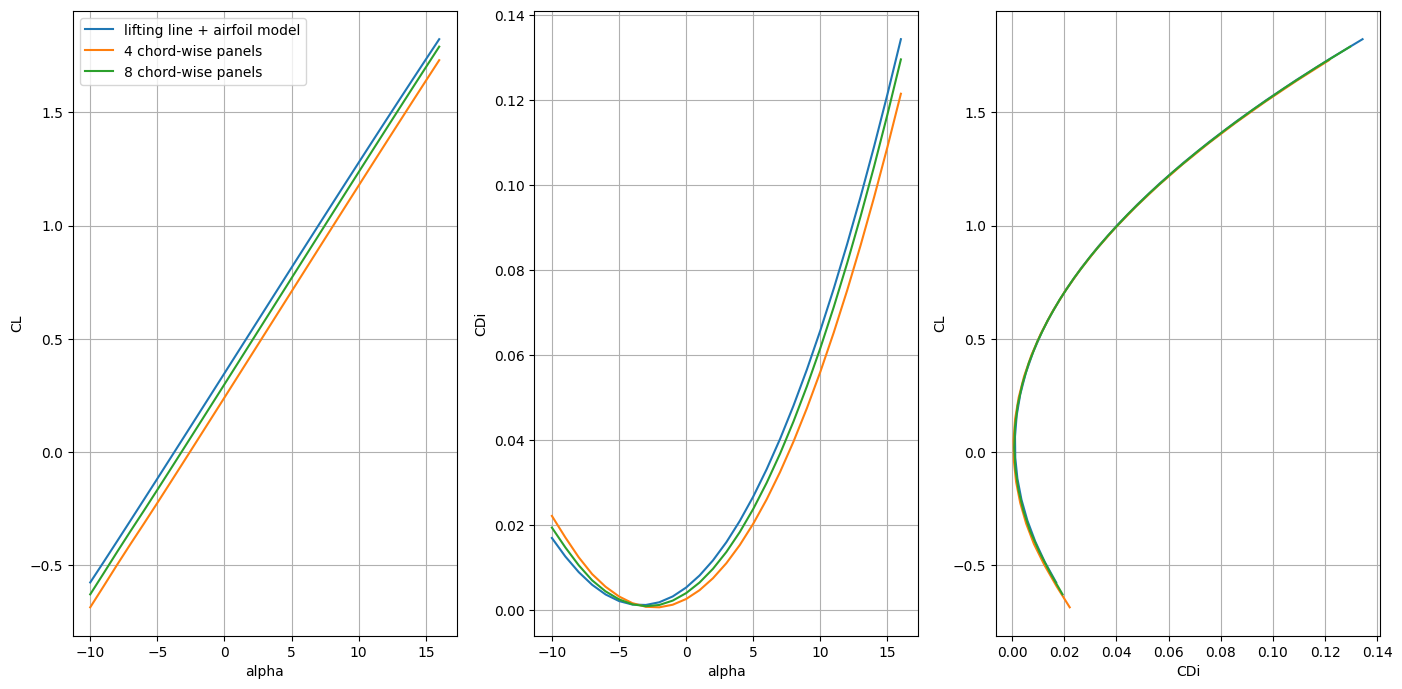

In [6]:
# Plotting the results
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(14, 7))
pitch = np.linspace(-10, 16, 27)
num_chord_wise = [4, 8, 12, 16, 20]


for i in range(3):
    if i == 0:
        label = "lifting line + airfoil model"
    else:
        label = f"{num_chord_wise[i-1]} chord-wise panels"
    CL = CL_list[i].value
    CDi = CDi_list[i].value
    axs[0].plot(pitch, CL, label=label)
    axs[0].grid()
    axs[0].set_xlabel("alpha")
    axs[0].set_ylabel("CL")
    axs[0].legend()

    axs[1].plot(pitch, CDi)
    axs[1].grid()
    axs[1].set_xlabel("alpha")
    axs[1].set_ylabel("CDi")

    axs[2].plot(CDi, CL)
    axs[2].grid()
    axs[2].set_xlabel("CDi")
    axs[2].set_ylabel("CL")

plt.tight_layout()
plt.show()
